Building a First Model

In the last notebook, we loaded in the data from retrosheet and did some processing to get the team level statistics.
We saved that data to a file called 'df_bp1.csv'
In this notebook, we will load in that data, do some initital data exploration, and then build and evaluate our first predictive model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli

from structureboost import log_loss
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
df = pd.read_csv('df_bp1.csv', low_memory=False)

Data Checks/Exploration

In [3]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205524 entries, 0 to 205523
Data columns (total 194 columns):
 #    Column                Non-Null Count   Dtype  
---   ------                --------------   -----  
 0    date                  205524 non-null  int64  
 1    dblheader_code        205524 non-null  int64  
 2    day_of_week           205524 non-null  object 
 3    team_v                205524 non-null  object 
 4    league_v              205524 non-null  object 
 5    game_no_v             205524 non-null  int64  
 6    team_h                205524 non-null  object 
 7    league_h              205524 non-null  object 
 8    game_no_h             205524 non-null  int64  
 9    runs_v                205524 non-null  int64  
 10   runs_h                205524 non-null  int64  
 11   outs_total            205524 non-null  int64  
 12   day_night             205524 non-null  object 
 13   completion_info       183 non-null     object 
 14   forfeit_info          43 non-null 

In [4]:
df.season.value_counts().sort_index()

1901    1110
1902    1117
1903    1114
1904    1249
1905    1237
1906    1228
1907    1233
1908    1244
1909    1241
1910    1249
1911    1237
1912    1232
1913    1234
1914    1880
1915    1864
1916    1247
1917    1247
1918    1016
1919    1118
1920    1234
1921    1229
1922    1238
1923    1233
1924    1231
1925    1228
1926    1234
1927    1236
1928    1231
1929    1229
1930    1234
1931    1236
1932    1233
1933    1226
1934    1223
1935    1228
1936    1238
1937    1239
1938    1223
1939    1231
1940    1236
1941    1244
1942    1224
1943    1238
1944    1242
1945    1230
1946    1242
1947    1243
1948    1237
1949    1240
1950    1238
1951    1239
1952    1239
1953    1240
1954    1237
1955    1234
1956    1239
1957    1235
1958    1235
1959    1238
1960    1236
1961    1430
1962    1621
1963    1619
1964    1626
1965    1623
1966    1615
1967    1620
1968    1625
1969    1946
1970    1944
1971    1938
1972    1859
1973    1943
1974    1945
1975    1934
1976    1939
1977    2103

In [5]:
hv_mean = df.home_victory.mean()
hv_mean

0.5387254043323407

In [6]:
df.run_diff.value_counts()

 1     37646
-1     24007
 2     18750
-2     18677
 3     15093
-3     14605
 4     11721
-4     11091
 5      8554
-5      8079
 6      6086
-6      5713
 7      4178
-7      4075
 8      3049
-8      2772
 9      2042
-9      1769
 10     1391
-10     1165
 11      813
 0       809
-11      738
 12      560
-12      482
 13      342
-13      326
-14      208
 14      199
 15      122
-15      103
-16       76
 16       70
 17       38
-17       37
-18       32
 18       27
 19       18
-19       15
 21        9
-20        7
 20        7
-21        7
-22        5
-23        4
 22        3
 23        1
 24        1
 25        1
-27        1
Name: run_diff, dtype: int64

In [7]:
df.outs_total.value_counts()

51     92225
54     84193
60      4142
53      4105
52      3597
66      2280
58      1875
59      1731
72      1244
64       992
65       946
57       783
78       719
70       553
71       542
42       503
63       464
84       402
48       382
77       314
36       282
39       275
76       273
30       263
69       238
90       217
82       190
83       173
45       145
75       138
96       127
33       108
89       104
88        67
81        62
102       59
95        52
94        50
27        47
41        41
108       41
40        31
34        31
31        31
46        30
100       29
87        28
101       27
47        24
29        24
28        23
43        23
93        21
37        21
114       20
35        20
32        19
44        16
38        16
107       14
49        13
120       13
106       13
113        9
0          9
111        8
126        8
50         8
105        7
112        6
99         6
118        5
132        5
138        2
131        2
144        2
156        1

In [8]:
df.home_victory[df.outs_total==53].mean()

0.9963459196102314

In [9]:
df.loc[(df.outs_total==53) & (df.home_victory!=1),:]

date  dblheader_code day_of_week team_v league_v  game_no_v  \
229     19010531               0         Fri    BLA       AL         25   
285     19010609               0         Sun    NY1       NL         31   
2204    19020928               2         Sun    CHA       AL        138   
6354    19060702               2         Mon    NYA       AL         64   
6802    19060903               2         Mon    PHA       AL        122   
9933    19090620               2         Sun    DET       AL         54   
24158   19200425               0         Sun    NY1       NL          7   
24993   19200820               2         Fri    CHA       AL        117   
30342   19250426               0         Sun    CLE       AL         11   
41159   19330903               2         Sun    NY1       NL        129   
76397   19620510               0         Thu    SFN       NL         29   
85445   19670819               0         Sat    KC1       AL        121   
89796   19700512               0         Tue    NYA       AL         33   
97721   19740604               0         Tue    TEX       AL         51   
165506  20050915               0         Thu    SLN       NL        148   

       team_h league_h  game_no_h  runs_v  runs_h  outs_total day_night  \
229       DET       AL         32       5       5          53         D   
285       CIN       NL         37      25      13          53         D   
2204      SLA       AL        140      10       4          53         D   
6354      PHA       AL         66       5       1          53         D   
6802      NYA       AL        121       3       3          53         D   
9933      SLA       AL         51       8       2          53         D   
24158     BRO       NL          9       5       2          53         D   
24993     PHA       AL        115       5       2          53         D   
30342     CHA       AL         13       7       2          53         D   
41159     BSN       NL        130       4       4          53         D   
76397     SLN       NL         26       6       0          53         N   
85445     WS2       AL        121       5       1          53         D   
89796     MIL       AL         32       9       5          53         N   
97721     CLE       AL         50       5       5          53         N   
165506    CHN       NL        147       6       1          53         N   

       completion_info forfeit_info protest_info ballpark_id  attendance  \
229                NaN            H          NaN       DET02      4500.0   
285                NaN            V          NaN       CIN05     17984.0   
2204               NaN          NaN          NaN       STL06     16678.0   
6354               NaN            V          NaN       PHI10     11893.0   
6802               NaN            H          NaN       NYC13         NaN   
9933               NaN          NaN          NaN       STL07     20000.0   
24158              NaN          NaN          NaN       NYC15     30000.0   
24993              NaN            V          NaN       PHI11         NaN   
30342              NaN            V          NaN       CHI10     44000.0   
41159              NaN          NaN          NaN       BOS08     42000.0   
76397              NaN          NaN          NaN       STL07     15567.0   
85445              NaN          NaN          NaN       WAS10      5568.0   
89796              NaN          NaN          NaN       MIL05      5382.0   
97721              NaN            V          NaN       CLE07     25134.0   
165506             NaN          NaN          NaN       CHI11     37849.0   

        game_minutes linescore_v linescore_h  AB_v   H_v  2B_v  3B_v  HR_v  \
229            120.0   002001002   002000210  37.0  11.0   0.0   0.0   0.0   
285            145.0   406300255   004000621  57.0  31.0  10.0   0.0   0.0   
2204             NaN   020040400   210100000  40.0  12.0   5.0   0.0   0.0   
6354           120.0   011000003   000000100  35.0  12.0   3.0   0.0   0.0   
680

In [10]:
df.game_no_h.value_counts().sort_index()

1      1314
2      1314
3      1313
4      1315
5      1314
6      1321
7      1307
8      1316
9      1325
10     1306
11     1318
12     1288
13     1298
14     1308
15     1313
16     1316
17     1334
18     1346
19     1350
20     1319
21     1292
22     1315
23     1313
24     1321
25     1305
26     1302
27     1316
28     1302
29     1317
30     1322
31     1348
32     1331
33     1311
34     1325
35     1303
36     1294
37     1270
38     1272
39     1294
40     1312
41     1346
42     1351
43     1353
44     1345
45     1348
46     1351
47     1327
48     1314
49     1298
50     1306
51     1303
52     1316
53     1310
54     1309
55     1306
56     1299
57     1322
58     1329
59     1334
60     1343
61     1302
62     1278
63     1277
64     1267
65     1279
66     1310
67     1293
68     1300
69     1326
70     1296
71     1298
72     1302
73     1294
74     1290
75     1292
76     1331
77     1308
78     1291
79     1304
80     1274
81     1285
82     1291
83     1310
84  

In [11]:
df[df.runs_v==df.runs_h]

date  dblheader_code day_of_week team_v league_v  game_no_v  \
76      19010504               0         Sat    CIN       NL         10   
128     19010513               0         Mon    BRO       NL         16   
188     19010524               0         Fri    WS1       AL         22   
229     19010531               0         Fri    BLA       AL         25   
230     19010531               0         Fri    WS1       AL         27   
263     19010605               0         Wed    BRO       NL         33   
307     19010612               0         Wed    BSN       NL         33   
329     19010616               0         Sun    NY1       NL         38   
353     19010619               0         Wed    PIT       NL         47   
436     19010701               0         Mon    PHA       AL         54   
593     19010723               0         Tue    WS1       AL         69   
758     19010815               2         Thu    BSN       NL         95   
798     19010821               0         Wed    DET       AL        101   
831     19010827               0         Tue    MLA       AL        108   
856     19010830               0         Fri    BLA       AL        104   
867     19010831               2         Sat    BOS       AL        110   
959     19010910               0         Tue    SLN       NL        122   
972     19010912               0         Thu    BOS       AL        122   
1183    19020501               0         Thu    CIN       NL         11   
1288    19020518               0         Sun    SLA       AL         19   
1412    19020606               0         Fri    PIT       NL         40   
1478    19020616               0         Mon    PIT       NL         46   
1484    19020617               0         Tue    BLA       AL         48   
1557    19020630               2         Mon    CLE       AL         59   
1633    19020709               0         Wed    BSN       NL         63   
1640    19020710               0         Thu    BRO       NL         71   
1688    19020717               0         Thu    SLA       AL         72   
1771    19020731               0         Thu    PHA       AL         77   
1780    19020801               0         Fri    PIT       NL         83   
1825    19020807               0         Thu    CHN       NL         93   
1853    19020811               0         Mon    CHN       NL         97   
1896    19020817               0         Sun    BRO       NL        103   
1898    19020818               0         Mon    DET       AL         96   
2001    19020901               2         Mon    BLA       AL        113   
2041    19020904               2         Thu    PIT       NL        120   
2064    19020907               2         Sun    WS1       AL        120   
2087    19020910               2         Wed    SLN       NL        123   
2099    19020911               2         Thu    SLN       NL        125   
2120    19020915               2         Mon    WS1       AL        127   
2152    19020920               2         Sat    DET       AL        130   
2201    19020927               2         Sat    BSN       NL        134   
2224    19021004               0         Sat    CHN       NL        141   
2243    19030420               0         Mon    BRO       NL          3   
2481    19030527               0         Wed    CIN       NL         35   
2634    19030622               2         Mon    CIN       NL         52   
2644    19030625               0         Thu    NYA       AL         48   
2682    19030629               0         Mon    CHN       NL         62   
2891    19030729               0         Wed    WS1       AL         83   
2907    19030731               0         Fri    BOS       AL         86   
3082    19030824               0         Mon    PIT       NL        108   
3105    19030829               2         Sat    BOS       AL        112   
3124    19030901               2         Tue    NYA       AL        108   
3160    19030905               0     

BEGIN MODELING

In [12]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [13]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [14]:
X_train.shape, X_valid.shape, X_test.shape, 

((188149, 4), (10615, 4), (4859, 4))

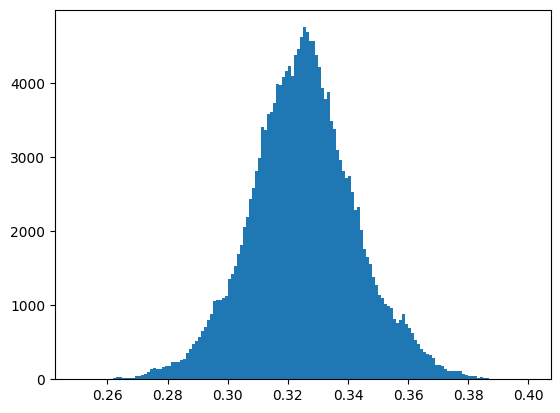

In [15]:
plt.hist(X_train.OBP_162_h, np.linspace(.25,.4,151));

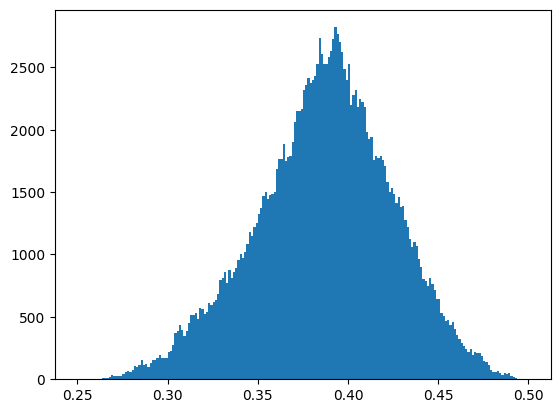

In [16]:
plt.hist(X_train.SLG_162_v, np.linspace(.25,.5,201));

In [17]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.690165
[20]	valid_0's binary_logloss: 0.689465
[30]	valid_0's binary_logloss: 0.688776
[40]	valid_0's binary_logloss: 0.688155
[50]	valid_0's binary_logloss: 0.687758
[60]	valid_0's binary_logloss: 0.68738
[70]	valid_0's binary_logloss: 0.687123
[80]	valid_0's binary_logloss: 0.686874
[90]	valid_0's binary_logloss: 0.686538
[100]	valid_0's binary_logloss: 0.686386
[110]	valid_0's binary_logloss: 0.686215
[120]	valid_0's binary_logloss: 0.686012
[130]	valid_0's binary_logloss: 0.685846
[140]	valid_0's binary_logloss: 0.685752
[150]	valid_0's binary_logloss: 0.685638
[160]	valid_0's binary_logloss: 0.685541
[170]	valid_0's binary_logloss: 0.685487
[180]	valid_0's binary_logloss: 0.685428
[190]	valid_0's binary_logloss: 0.685351
[200]	valid_0's binary_logloss: 0.685303
[210]	valid_0's binary_logloss: 0.685251
[220]	valid_0's binary_logloss: 0.685213
[230]	valid_0's binary_logloss: 0.685169
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [18]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.683490243306594, 0.6905494782307997)

In [19]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

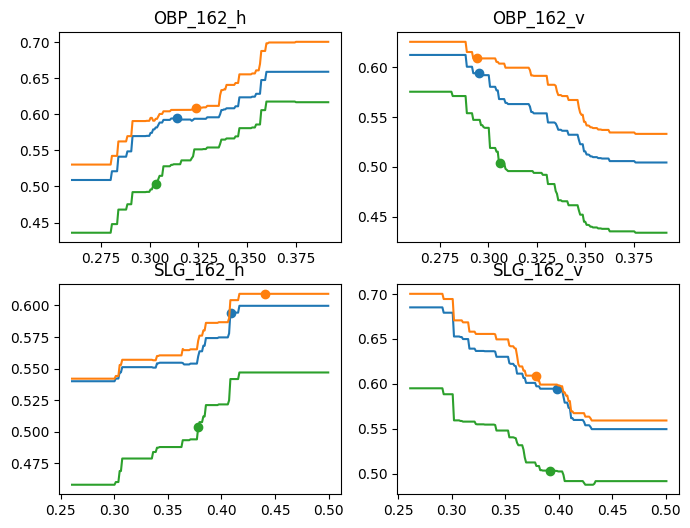

In [20]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=2)

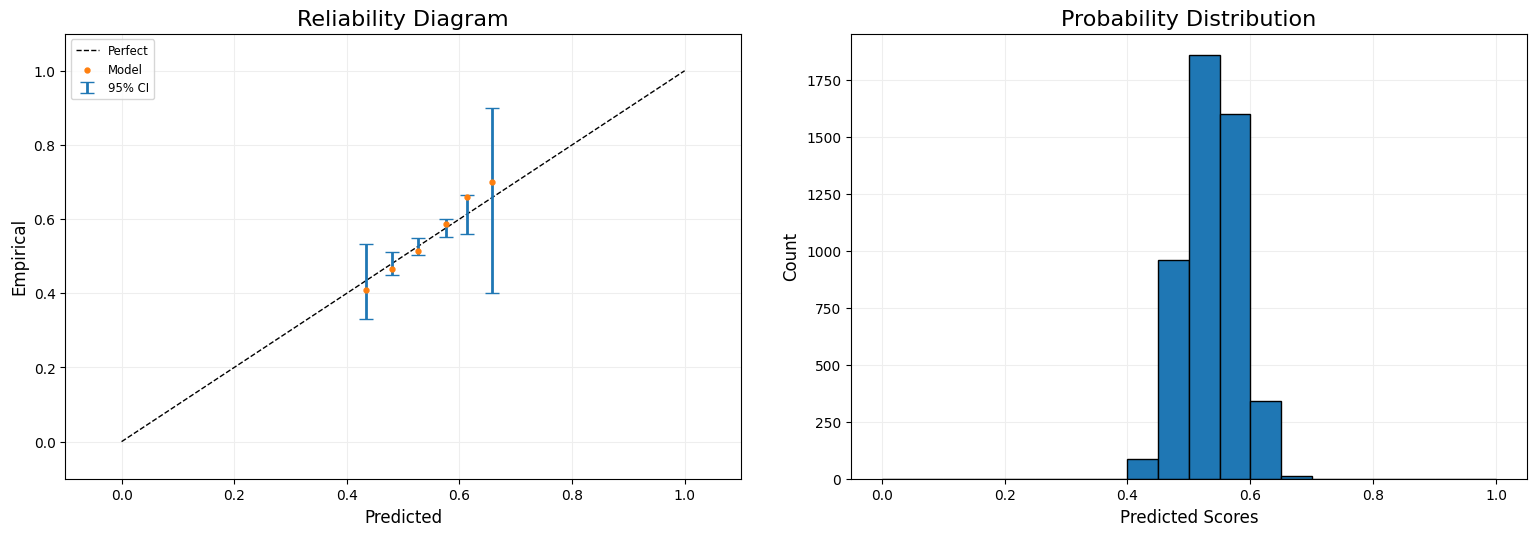

In [21]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [22]:
fc = stb.get_basic_config(X_train, stb.default_config_dict())

stb1 = stb.StructureBoost(max_depth=3, learning_rate=.02, feature_configs = fc, num_trees=2000)
stb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5)

i=0, eval_set_loss = 0.6909454464947197
i=10, eval_set_loss = 0.6899347525880603
i=20, eval_set_loss = 0.6890875911200885
i=30, eval_set_loss = 0.6883108459659298
i=40, eval_set_loss = 0.6877059272858327
i=50, eval_set_loss = 0.6872818256228983
i=60, eval_set_loss = 0.6868887622996477
i=70, eval_set_loss = 0.6865202842562697
i=80, eval_set_loss = 0.6863040111290903
i=90, eval_set_loss = 0.686041083334398
i=100, eval_set_loss = 0.6858272826532833
i=110, eval_set_loss = 0.6856570854818376
i=120, eval_set_loss = 0.685518771165418
i=130, eval_set_loss = 0.6853196732253382
i=140, eval_set_loss = 0.6851701180314232
i=150, eval_set_loss = 0.6850659732033428
i=160, eval_set_loss = 0.6849983987661176
i=170, eval_set_loss = 0.68492169988366
i=180, eval_set_loss = 0.6848402790265296
i=190, eval_set_loss = 0.6847981974278106
i=200, eval_set_loss = 0.6847500631270109
i=210, eval_set_loss = 0.6846874982165688
i=220, eval_set_loss = 0.6846352506937183
i=230, eval_set_loss = 0.6845893980213126
i=240, 

In [23]:
preds_stb = stb1.predict(X_test)
log_loss(y_test, preds_stb), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6834375710245778, 0.6905494782307997)

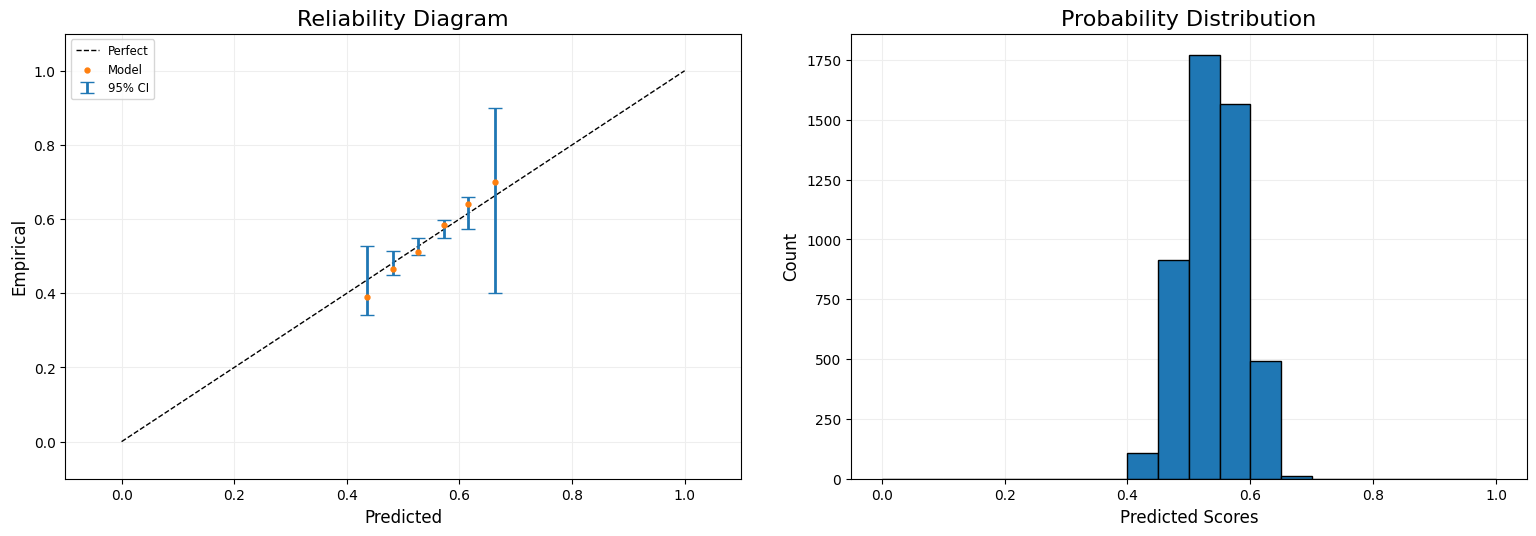

In [24]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_stb, show_histogram=True);

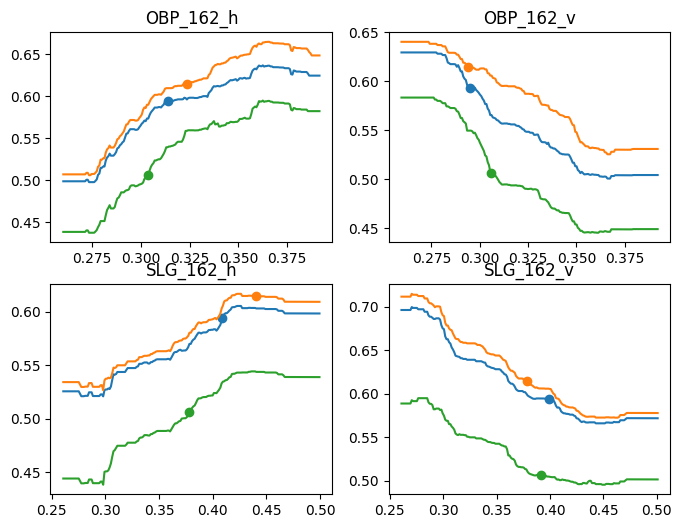

In [25]:
rd= mli.get_range_dict(X_train)
mli.ice_plot(stb1, plot_pts, X_test.columns, rd, plots_per_row=2)